### ⚠️ Roteiro para executar códigos do notebook no Google Colab(oratory) com GPU_


**PASSO 1:** Acessar https://colab.research.google.com/ $\to$ `Upload` $\to$ `escolher arquivo .ipynb`

**PASSO 2:** Acessar MENU `Ambiente de execução` $\to$ `Alterar tipo do ambiente` $\to$ `GPU` $\to$ `Salvar`

**PASSO 3:** `Barra lateral esquerda` $\to$ `Icone de arquivo` $\to$ `Icone de upload` $\to$ `escolher arquivo auxiliar` (ex. `aux.py`)

**PASSOS 4, 5, 6 e 7:** ver células a seguir...

In [ ]:
#### PASSO 4: VER DETALHES DA GPU
#### Descomente a linha abaixo e execute

#!nvidia-smi

In [ ]:
#### PASSO 5: VER VERSÃO CUDA INSTALADA
#### Descomente a linha abaixo e execute

#!nvcc --version 

In [ ]:
#### PASSO 6: INSTALAR versão MXNET com versão CUDA correspondente
#### Descomente uma das linhas abaixo e execute

#!pip install -U mxnet-cu110==1.8.0 
#!pip install -U mxnet-cu101==1.7.0

In [ ]:
#### PASSO 7: VERIFICAR se MXNET "enxerga" a GPU
#### Se estiver enxergando, será impresso algo como gpu(0),
#### caso contrário, será impresso algo como cpu(0)
#### Descomente o código abaixo e execute

#from mxnet import npx
#def try_all_gpus():
#    devices = [npx.gpu(i) for i in range(npx.num_gpus())]
#    return devices if devices else [npx.cpu()]
#try_all_gpus()

# Modelos para novos datasets

Fashion-MNIST: 60K imagens de treinamento e 10 categorias   
ImageNet: >10M imagens de treinamento e >1K categorias    

Usualmente.... #Fashion-MNIST < **#MeuDataset** < #ImageNet  

### Como montar nosso dataset?

Uma rede neuronal pode ser dividida aproximadamente em duas partes:
- Um extrator de características mapeia pixels brutos em características linearmente separáveis
- Um classificador linear para tomar a decisão sobre a classe

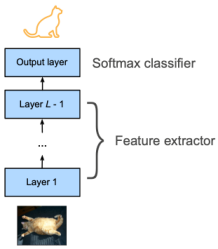

### 1. Enriquecer/Diversificar dados existentes (_Augmentation_)

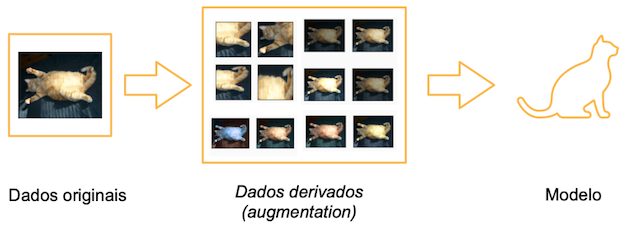

### 2. Transferir aprendizado (_Transfer learning_) com _Fine Tuning_

Reaproveitar parte do conhecimento aprendido de um dataset rico já conhecido para o novo.    
**Passo 1 $\to$ Passo 2 $\to$ Passo 3 $\to$ Passo 4**    

(Ex.)   
Imagens da base ImageNet não estão relacionadas ao reconhecimento de automóveis, mas parte da rede treinada para o ImageNet extrai características mais gerais que servem para qualquer tipo de objeto inédito: identificação de bordas, texturas, formas e composição.

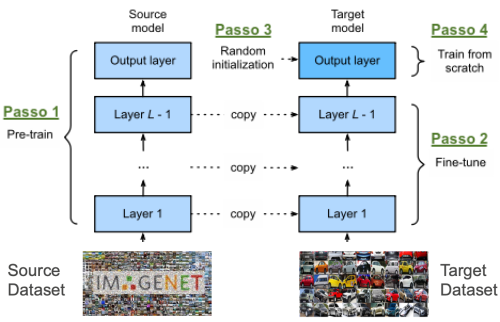

**Novo treinamento**: trabalho normal de treinamento, mas com **forte regularização**
- Pequena taxa de aprendizagem (_lr_)
- Menos épocas

**Re-utilizar parâmetros do classificador**
- O dataset de origem pode conter algumas categorias do novo dataset
- Usar os vetores de peso correspondentes do modelo pré-treinado durante a inicialização

**Corrigir/adaptar algumas camadas**
- As redes neurais aprendem representações hierárquicas de características: (i) características de baixo nível são universais enquanto que (ii) características de alto nível são mais relacionadas aos objetos específicos do dataset

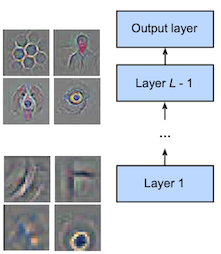

- Fixar os parâmetros da camada inferior durante o ajuste fino: outro **forte regularizador**

# Exemplo: reconhecimento de Hot Dogs

**Objetivo:** identificar se uma imagem contém um cachorro-quente.

**Método:** aplicar _fine-tuning_ no modelo _ResNet_ treinado em um subconjunto do ImageNet (contendo algumas imagens de cachorro-quente). 



In [1]:
%matplotlib inline
import aux as aux
from mxnet import gluon, init, nd, npx
from mxnet.gluon import data as gdata, loss as gloss, model_zoo
from mxnet.gluon import utils as gutils
import os
import zipfile

npx.set_np()

## Download/Extração do dataset

**ATENÇÃO:** Caso já tenha realizado download da base e descompactado, NÃO EXECUTAR a célula abaixo!

In [ ]:
# Para realizar download do arquivo .zip
data_dir = '.'
base_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/'
fname = gutils.download(
    base_url + 'gluon/dataset/hotdog.zip',
    path=data_dir, sha1_hash='fba480ffa8aa7e0febbb511d181409f899b9baa5')

# Extrair subdiretorio de treino e teste contendo:
# 1. imagens de hotdogs e 2. imagens que não são de hotdogs
with zipfile.ZipFile(fname, 'r') as z:
    z.extractall(data_dir)

## Leitura do dataset 

In [ ]:
data_dir = '.'
train_imgs = gdata.vision.ImageFolderDataset(
    os.path.join(data_dir, 'hotdog/train'))
test_imgs = gdata.vision.ImageFolderDataset(
    os.path.join(data_dir, 'hotdog/test'))

# Visualização de algumas imagens da base de treinamento (hotdogs acima)
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
aux.show_images(hotdogs + not_hotdogs, 2, 8, scale=2);

## _Image Augmentation_

In [ ]:
# Usamos a média e a variância dos três canais RGB para normalizar o canal de imagem.
normalize = gdata.vision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Algumas operações para enriquecer/diversificar as imagens
train_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomResizedCrop(224),
    gdata.vision.transforms.RandomFlipLeftRight(),
    gdata.vision.transforms.ToTensor(),
    normalize])

test_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.Resize(256),
    gdata.vision.transforms.CenterCrop(224),
    gdata.vision.transforms.ToTensor(),
    normalize])

## Download do modelo de pré-treinamento

---> pacote `model_zoo` do `Gluon`: https://cv.gluon.ai/model_zoo/index.html (mais de 170 modelos pré-treinados)

In [ ]:
# Realiza download e carrega os parâmetros do modelo pré-treinado. 
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)
pretrained_net.output

## _Fine Tuning_

Nova rede neuronal é criada semelhante ao modelo pré-treinado. 
O número final de saídas é igual ao número de classes do novo datatset.

A instância do modelo pré-treinado contém duas variáveis membros: `features` e `output`.     
`features` contém todas as camadas do modelo, exceto a camada de saída;        
`output` é a camada de saída do modelo.   

Objetivo desta divisão é facilitar o fine tuning dos parâmetros do modelo de todas as camadas, exceto a camada de saída.

In [ ]:
# Apenas duas classes na saída: hotdog=True vs hotdog=False
finetune_net = model_zoo.vision.resnet18_v2(classes=2) 

# Reaproveita parâmetros pré-treinados das camadas anteriores (features)
finetune_net.features = pretrained_net.features

# Apenas parâmetros da camada de saída (output) são inicializados aleatoriamente...
finetune_net.output.initialize(init.Xavier())
# ... e usualmente precisam de taxa de aprendizado bem maior para aprender do "zero"
finetune_net.output.collect_params().setattr('lr_mult', 10) #10 vezes

In [ ]:
# Definição da função de treinamento para o tuning
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5):
    train_iter = gluon.data.DataLoader(train_imgs.transform_first(train_augs),
                                       batch_size, shuffle=True)
    test_iter = gluon.data.DataLoader(test_imgs.transform_first(test_augs),
                                      batch_size)
    devices = aux.try_all_gpus()
    net.collect_params().reset_ctx(devices)
    net.hybridize()
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate,
        'wd': 0.001})
    aux.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

In [ ]:
# Treinamento em si: taxa de aprendizado pequena para fine tuning dos parâmetros obtidos no pré-treinamento
train_fine_tuning(finetune_net, 0.01)

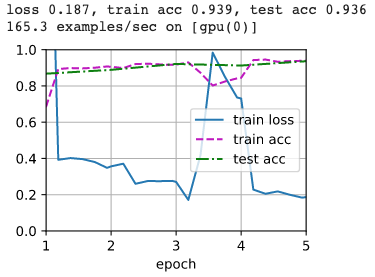

**_*executado no Google Colab (GPU: Tesla P100)_**

### Para comparação: treinamento de todo o modelo do "zero"

Todos os parâmetros são inicalizados aleatoriamente. Como o modelo inteiro precisa ser treinado a partir do zero, podemos utilizar uma taxa de aprendizado maior.

$\implies$ O modelo com uso de fine tuning tende a ter maior acurácia porque os valores iniciais dos parâmetros são melhores.

In [ ]:
scratch_net = model_zoo.vision.resnet18_v2(classes=2)

# Todas as camdas são inicializados aleatoriamente...
scratch_net.initialize(init=init.Xavier())
#... e a rede toda usa taxa de aprendizado maior.
train_fine_tuning(scratch_net, 0.1)

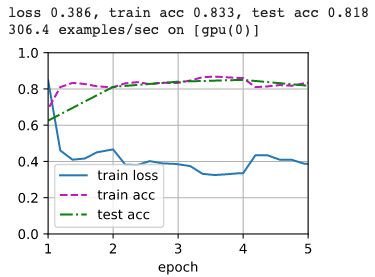

**_*executado no Google Colab (GPU: Tesla P100)_**

# Referências para estudo

## Seção 13.1 e 13.2 de [Dive into Deep Learning](https://d2l.ai/index.html)